Optimal Weights:
  Gradient Boosting (GB): 0.80
  Random Forest (RF):     0.20
Best Weighted Ensemble Accuracy on validation set: 0.5824

Weighted Average Ensemble Performance:
Accuracy:  0.5824
Precision: 0.5917
Recall:    0.5824
F1 Score:  0.5757


/Users/iasonastsagkaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iasonastsagkaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iasonastsagkaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

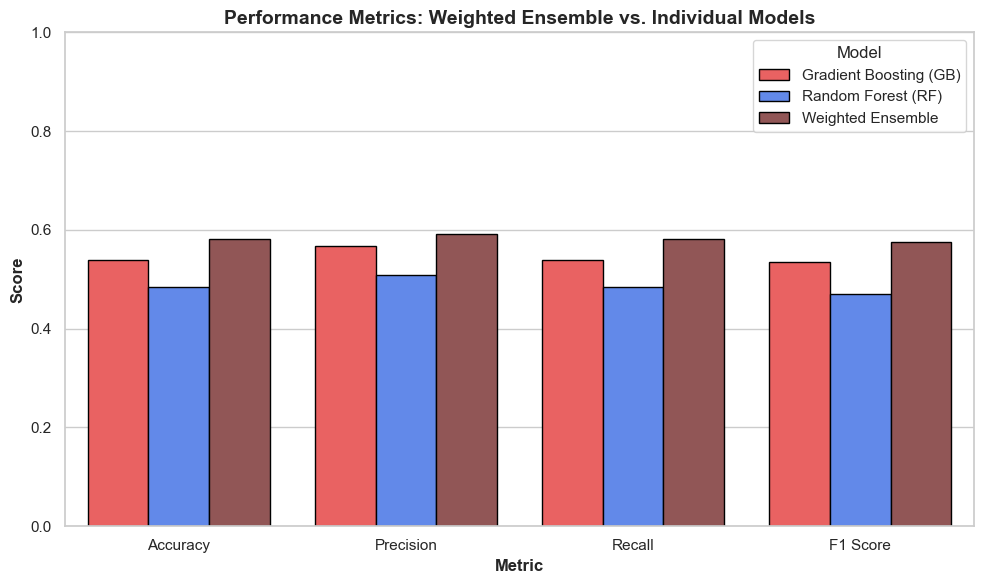

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Load the Data
# ---------------------------
df = pd.read_csv('final_embeddings_with_class.csv')
target_column = 'class'
X = df.drop(columns=[target_column]).values
y = df[target_column].values

# ---------------------------
# 2. Split the Data (with stratification)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# ---------------------------
# 3. Further Split Training Data for Calibration (Hold-Out Calibration Set)
# ---------------------------
# Increase the calibration set size to ensure all classes are well represented.
X_train_model, X_calib, y_train_model, y_calib = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# ---------------------------
# 4. Train and Calibrate Individual Classifiers Using the Calibration Set
# ---------------------------
# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, 
                                n_iter_no_change=20, random_state=42)
gb.fit(X_train_model, y_train_model)
# Calibrate using the hold-out calibration set; note the new parameter name "estimator"
calibrated_gb = CalibratedClassifierCV(estimator=gb, cv="prefit", method='sigmoid')
calibrated_gb.fit(X_calib, y_calib)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_model, y_train_model)
calibrated_rf = CalibratedClassifierCV(estimator=rf, cv="prefit", method='sigmoid')
calibrated_rf.fit(X_calib, y_calib)

# ---------------------------
# 5. Obtain Predicted Probabilities on the Test Set
# ---------------------------
probs_gb = calibrated_gb.predict_proba(X_test)
probs_rf = calibrated_rf.predict_proba(X_test)

# ---------------------------
# 6. Grid Search for Optimal Weights for the Weighted Average Ensemble
# ---------------------------
# Search for the best weight for RF (rf_weight) in [0, 1]; GB gets (1 - rf_weight)
weight_options = np.linspace(0, 1, 11)
best_acc = 0
best_weight_rf = 0

for weight_rf in weight_options:
    weight_gb = 1 - weight_rf
    weighted_probs = (weight_gb * probs_gb) + (weight_rf * probs_rf)
    # If classes are 1-indexed, adjust predictions by adding 1 after argmax.
    weighted_preds = np.argmax(weighted_probs, axis=1) + 1
    acc = accuracy_score(y_test, weighted_preds)
    if acc > best_acc:
        best_acc = acc
        best_weight_rf = weight_rf

best_weight_gb = 1 - best_weight_rf

print("Optimal Weights:")
print("  Gradient Boosting (GB): {:.2f}".format(best_weight_gb))
print("  Random Forest (RF):     {:.2f}".format(best_weight_rf))
print("Best Weighted Ensemble Accuracy on validation set: {:.4f}".format(best_acc))

# ---------------------------
# 7. Evaluate the Weighted Ensemble with Optimal Weights
# ---------------------------
weighted_probs = (best_weight_gb * probs_gb) + (best_weight_rf * probs_rf)
weighted_preds = np.argmax(weighted_probs, axis=1) + 1  # Adjust for 1-indexed classes

accuracy_weighted = accuracy_score(y_test, weighted_preds)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, weighted_preds, average='weighted'
)

print("\nWeighted Average Ensemble Performance:")
print("Accuracy:  {:.4f}".format(accuracy_weighted))
print("Precision: {:.4f}".format(precision_weighted))
print("Recall:    {:.4f}".format(recall_weighted))
print("F1 Score:  {:.4f}".format(f1_weighted))

# ---------------------------
# 8. (Optional) Plotting the Results for Comparison
# ---------------------------
# Get predictions from each calibrated classifier
gb_preds = calibrated_gb.predict(X_test)
rf_preds = calibrated_rf.predict(X_test)
accuracy_gb = accuracy_score(y_test, gb_preds)
accuracy_rf = accuracy_score(y_test, rf_preds)
precision_gb, recall_gb, f1_gb, _ = precision_recall_fscore_support(y_test, gb_preds, average='weighted')
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, rf_preds, average='weighted')

data = [
    ["Gradient Boosting (GB)", accuracy_gb, precision_gb, recall_gb, f1_gb],
    ["Random Forest (RF)", accuracy_rf, precision_rf, recall_rf, f1_rf],
    ["Weighted Ensemble", accuracy_weighted, precision_weighted, recall_weighted, f1_weighted]
]
df_results = pd.DataFrame(data, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, ci=None, edgecolor='black', palette=["#FF4C4C", "#4C80FF", "#9B4C4C"])
plt.ylim(0, 1)
plt.title("Performance Metrics: Weighted Ensemble vs. Individual Models", fontsize=14, fontweight='bold')
plt.xlabel("Metric", fontsize=12, fontweight='bold')
plt.ylabel("Score", fontsize=12, fontweight='bold')
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()
